'LinGapE' benchmark against 'XY-static-allocation'
=========================================

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from bandpy import run_trials
from bandpy.env import RandomLinearBandit, CanonicalLinearBandit
from bandpy.controller import DecentralizedController
from bandpy.agents import GreedyLinGapE
from bandpy.utils import check_random_state

In [2]:
def plot_linear_bandit(arms, theta):
    """ Plot in 2D the arms/theta configuration."""
    plt.figure(len(arms), figsize=(3, 3))
    origin = np.array([[0.0, 0.0], [0.0, 0.0]]) # origin point
    for arm in arms:
        plt.quiver(*origin, arm[0], arm[1], angles='xy', scale_units='xy', scale=1, color='tab:blue')
    plt.quiver(*origin, theta[0], theta[1], angles='xy', scale_units='xy', scale=1, color='tab:red')
    max_x = np.max([np.abs(arm[0]) for arm in arms] + [np.abs(theta[0])])
    plt.xlim(-max_x, max_x)
    max_y = np.max([np.abs(arm[1]) for arm in arms] + [np.abs(theta[1])])
    plt.ylim(-max_y, max_y)
    plt.grid()
    plt.title(f"Linear bandit configuration (K={len(arms)})")
    plt.tight_layout()
    plt.show()

Global variables
-----------------------

In [3]:
plt.style.use('tableau-colorblind10')
N_AGENTS = 1  # single agent case only
MAX_RANDINT = 10000
n_trials = 1
max_T = 1000000
seed = None
n_jobs = 7
verbose = False

Experiment on n-arms influence
==========================

Experiment variables
------------------------------

In [4]:
K_min = 20
K_max = 100
n_points = 4
l_K = np.linspace(K_min, K_max, n_points, dtype=int)
l_n_samples, l_err = [], []

In [5]:
print(f"[Main] running simulations with n-arms={l_K}.")

[Main] running simulations with n-arms=[ 20  46  73 100].


Running the experiment
----------------------------------

[Main] Running simulation for n-trials=001 and for n-arms=020.


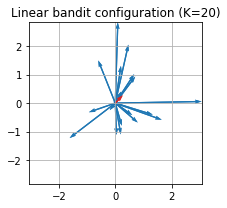

[Main] Running simulation for n-trials=001 and for n-arms=046.


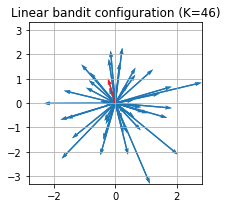

[Main] Running simulation for n-trials=001 and for n-arms=073.


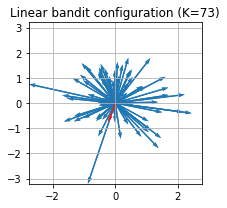

[Main] Running simulation for n-trials=001 and for n-arms=100.


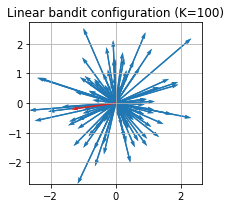

In [6]:
for K in l_K:

    print(f"[Main] Running simulation for n-trials={n_trials:03d} and for n-arms={K:03d}.")

    env = RandomLinearBandit(d=2, K=K, T=max_T, sigma=0.1, seed=seed)
    
    plot_linear_bandit(env.arms, env.theta)
    
    agent_kwargs = {'arms': env.arms,
                    'epsilon': 0.1,
                    'delta': 0.001,
                    'R': 1.0,
                    'S': np.linalg.norm(env.theta),
                    'lbda': 1.0,
                    }
    controller = DecentralizedController(N=N_AGENTS,
                                         agent_cls=GreedyLinGapE,
                                         agent_kwargs=agent_kwargs)
    
    rng = check_random_state(seed)
    seeds = rng.randint(MAX_RANDINT, size=n_trials)

    trial_results = run_trials(
                env, controller, enable_controller_early_stopping=True,
                seeds=seeds, n_jobs=n_jobs, verbose=verbose)

    TT, err = [], []
    for trial_result in trial_results:

        trial_T, _, trial_best_arms = trial_result

        err.append(int(trial_best_arms['agent_0'] != env.best_arm))
        TT.append(trial_T)

    l_err.append(np.mean(err))
    l_n_samples.append(np.mean(TT))

Printing results
----------------------

In [7]:
for K, n_samples, err in zip(l_K, l_n_samples, l_err):
    print(f"[K={K:03d}] mean_n_samples={n_samples:.2e} | err={err:.1f}")

[K=020] mean_n_samples=8.28e+03 | err=0.0
[K=046] mean_n_samples=8.70e+01 | err=0.0
[K=073] mean_n_samples=7.60e+01 | err=0.0
[K=100] mean_n_samples=1.03e+02 | err=0.0


Plotting results
----------------------

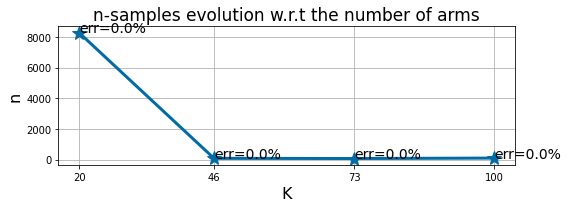

In [8]:
l_K, l_n_samples = np.array(l_K), np.array(l_n_samples)
l_err = np.array(l_err)

plt.figure(figsize=(8, 3))

plt.plot(l_K, l_n_samples, '*-', lw=3.0, markersize=15.0)
for i, err in enumerate(l_err):
    text = f"err={100. * l_err[i]:.1f}%"
    plt.text(x=l_K[i], y=l_n_samples[i], s=text, fontsize=14)

plt.xticks(l_K)
plt.xlabel("K", fontsize=16)
plt.ylabel("n", fontsize=16)
plt.grid()
plt.title("n-samples evolution w.r.t the number of arms", fontsize=17)
plt.tight_layout()
plt.show()

Experiment on dimension influence
=============================

Experiment variables
------------------------------

In [9]:
delta_min = -2.0
delta_max = 0.0
n_points = 4
l_delta = np.logspace(delta_min, delta_max, n_points, dtype=float)
l_n_samples, l_err = [], []

In [10]:
print(f"[Main] running simulations with delta={l_delta}.")

[Main] running simulations with delta=[0.01       0.04641589 0.21544347 1.        ].


Running the experiment
----------------------------------

[Main] Running simulation for n-trials=001 and for delta=0.0100.


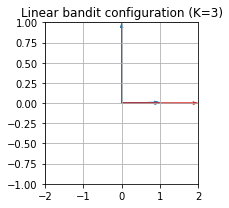

[Main] Running simulation for n-trials=001 and for delta=0.0464.


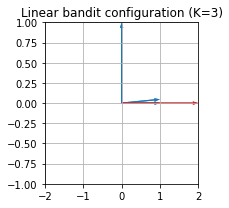

[Main] Running simulation for n-trials=001 and for delta=0.2154.


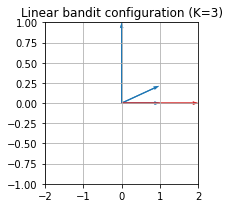

[Main] Running simulation for n-trials=001 and for delta=1.0000.


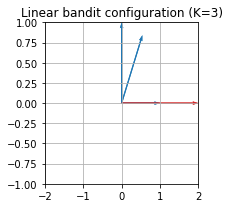

In [11]:
for delta in l_delta:

    print(f"[Main] Running simulation for n-trials={n_trials:03d} and for delta={delta:0.4f}.")

    env = CanonicalLinearBandit(d=2, delta=delta, T=max_T, seed=seed)
    
    plot_linear_bandit(env.arms, env.theta)
    
    agent_kwargs = {'arms': env.arms,
                    'epsilon': 0.0,
                    'delta': 0.001,
                    'R': 1.0,
                    'S': np.linalg.norm(env.theta),
                    'lbda': 1.0,
                    }
    controller = DecentralizedController(N=N_AGENTS,
                                         agent_cls=GreedyLinGapE,
                                         agent_kwargs=agent_kwargs)

    rng = check_random_state(seed)
    seeds = rng.randint(MAX_RANDINT, size=n_trials)

    trial_results = run_trials(
                env, controller, enable_controller_early_stopping=True,
                seeds=seeds, n_jobs=n_jobs, verbose=verbose)

    TT, err = [], []
    for trial_result in trial_results:

        trial_T, _, trial_best_arms = trial_result

        err.append(int(trial_best_arms['agent_0'] != env.best_arm))
        TT.append(trial_T)

    l_err.append(np.mean(err))
    l_n_samples.append(np.mean(TT))

Printing results
----------------------

In [12]:
for delta, n_samples, err in zip(l_delta, l_n_samples, l_err):
    print(f"[delta={delta:0.4f}] mean_n_samples={n_samples:.2e} | err={err:.1f}")

[delta=0.0100] mean_n_samples=5.39e+05 | err=0.0
[delta=0.0464] mean_n_samples=1.74e+04 | err=0.0
[delta=0.2154] mean_n_samples=1.11e+03 | err=0.0
[delta=1.0000] mean_n_samples=1.13e+02 | err=0.0


Plotting results
----------------------

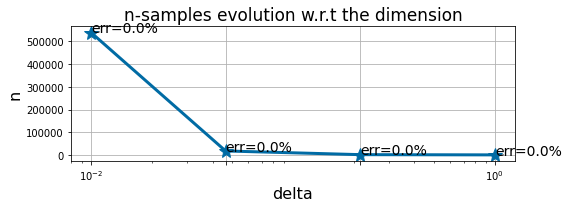

In [13]:
l_delta, l_n_samples = np.array(l_delta), np.array(l_n_samples)
l_err = np.array(l_err)

plt.figure(figsize=(8, 3))

plt.semilogx(l_delta, l_n_samples, '*-', lw=3.0, markersize=15.0)
for i, err in enumerate(l_err):
    text = f"err={100. * l_err[i]:.1f}%"
    plt.text(x=l_delta[i], y=l_n_samples[i], s=text, fontsize=14)

plt.xticks(l_delta)
plt.xlabel("delta", fontsize=16)
plt.ylabel("n", fontsize=16)
plt.grid()
plt.title("n-samples evolution w.r.t the dimension", fontsize=17)
plt.tight_layout()
plt.show()